<a href="https://colab.research.google.com/github/aupe/apai/blob/master/dl_cv_pet_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Oxford Pets

## Setup

In [0]:
SETUP = True

In [0]:
# a = []
# while(1):
#     a.append('1')

In [134]:
import os

try:
    %tensorflow_version 2.x
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    %matplotlib inline
except:
    %load_ext lab_black
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Mounted at /content/drive


In [0]:
# if SETUP:
#     !bash ./setup.sh

In [3]:
!pip install -q -U toai

     |████████████████████████████████| 296kB 4.1MB/s 
     |████████████████████████████████| 153kB 14.7MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 
     |████████████████████████████████| 552kB 13.5MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 122kB 20.4MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [4]:
print(__import__("toai").__version__)
print(__import__("tensorflow").__version__)

0.4.1
2.1.0


In [5]:
from toai.imports import *
from toai.image import ImageAugmentor, ImageParser, ImageResizer, ImageDataContainer
from toai.data.utils import split_df
from toai.encode import CategoricalEncoder
from typing import *
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from glob import glob
from matplotlib.patches import Rectangle

/usr/local/lib/python3.6/dist-packages/toai/imports.py:71: UserWarning: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
  warnings.warn(str(error))


## Loading the data

In [0]:
DATA_DIR = Path("data/pets")
DATA_DIR.mkdir(parents=True, exist_ok=True)


In [0]:
TEMP_DIR = Path('./drive/My Drive/Projects/16_Advanced_CV/temp/pets')

In [0]:
# if SETUP:
#     shutil.rmtree(str(DATA_DIR))
#     DATA_DIR.mkdir(parents=True, exist_ok=True)
#     TEMP_DIR.mkdir(parents=True, exist_ok=True)
#     kaggle.api.authenticate()
#     kaggle.api.dataset_download_files(
#         dataset="jutrera/stanford-car-dataset-by-classes-folder",
#         path=DATA_DIR,
#         unzip=True,
#     )


In [0]:
def setup_kaggle():
    !rm -rf /root/.kaggle
    x = !ls kaggle.json
    assert x == ['kaggle.json'], 'Upload kaggle.json'
    !mkdir /root/.kaggle
    !mv kaggle.json /root/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    
setup_kaggle()

In [0]:
DOWNLOAD_DATA = True

if DOWNLOAD_DATA:
    !kaggle datasets download -q -d devdgohil/the-oxfordiiit-pet-dataset --unzip -p {str(DATA_DIR)}

In [0]:
import xml.etree.ElementTree as ET

In [0]:
tree = ET.parse(DATA_DIR/'annotations/annotations/xmls/Abyssinian_1.xml')
root = tree.getroot()

In [12]:
root.tag

'annotation'

In [13]:
root.attrib

{}

In [14]:
for child in root:
    print(child.tag, child.attrib)

folder {}
filename {}
source {}
size {}
segmented {}
object {}


In [15]:
[elem.tag for elem in root.iter()]

['annotation',
 'folder',
 'filename',
 'source',
 'database',
 'annotation',
 'image',
 'size',
 'width',
 'height',
 'depth',
 'segmented',
 'object',
 'name',
 'pose',
 'truncated',
 'occluded',
 'bndbox',
 'xmin',
 'ymin',
 'xmax',
 'ymax',
 'difficult']

In [16]:
ET.tostring(root, encoding='utf8').decode('utf8')

"<?xml version='1.0' encoding='utf8'?>\n<annotation><folder>OXIIIT</folder><filename>Abyssinian_1.jpg</filename><source><database>OXFORD-IIIT Pet Dataset</database><annotation>OXIIIT</annotation><image>flickr</image></source><size><width>600</width><height>400</height><depth>3</depth></size><segmented>0</segmented><object><name>cat</name><pose>Frontal</pose><truncated>0</truncated><occluded>0</occluded><bndbox><xmin>333</xmin><ymin>72</ymin><xmax>425</xmax><ymax>158</ymax></bndbox><difficult>0</difficult></object></annotation>"

In [0]:
origin_img1 = Image.open(str(DATA_DIR/'images/images/Abyssinian_1.jpg'))

In [0]:
from PIL import Image, ImageDraw

In [0]:
%matplotlib inline

In [0]:
origin_img

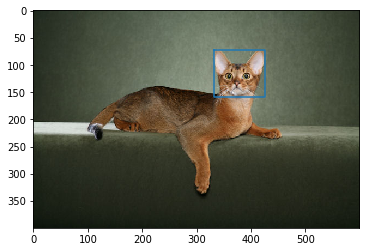

In [0]:
plt.imshow(plt.imread(str(DATA_DIR/'images/images/Abyssinian_1.jpg')))
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin])

In [0]:
def save_cropped_img(path, annotation):
    tree = ET.parse(annotation)
    xmin = int(tree.getroot().findall('.//xmin')[0].text)
    xmax = int(tree.getroot().findall('.//xmax')[0].text)
    ymin = int(tree.getroot().findall('.//ymin')[0].text)
    ymax = int(tree.getroot().findall('.//ymax')[0].text)


In [0]:
xmin = int(tree.getroot().findall('.//xmin')[0].text)
xmax = int(tree.getroot().findall('.//xmax')[0].text)
ymin = int(tree.getroot().findall('.//ymin')[0].text)
ymax = int(tree.getroot().findall('.//ymax')[0].text)
filename = tree.getroot().findall('.//filename')[0].text
width = tree.getroot().findall('.//width')[0].text
height= tree.getroot().findall('.//height')[0].text
depth= tree.getroot().findall('.//depth')[0].text
name= tree.getroot().findall('.//name')[0].text

In [22]:
filename, xmin, xmax,ymin, ymax, width, height, depth, name

(333, 425, 72, 158, 'Abyssinian_1.jpg', '600', '400', '3', 'cat')

In [0]:
# df['V'] = df['V'].str.split('-').str[0]

(333, 425, 72, 158)

In [0]:
df_cols = ['filename', 'xmin', 'xmax','ymin', 'ymax',  'width', 'height', 'depth', 'name']

In [0]:
annotations = sorted(os.listdir(DATA_DIR/'annotations/annotations/xmls'))

In [147]:
len(annotations)

3686

In [0]:
df = pd.DataFrame(columns = df_cols)

In [170]:
df

,filename,xmin,xmax,ymin,ymax,width,height,depth,name


In [171]:
for xml_file in progress_bar(annotations):
    tree = ET.parse(str(DATA_DIR/'annotations/annotations/xmls/') + '/' + xml_file)

    for node in xroot:
        filename = tree.getroot().findall('.//filename')[0].text
        xmin = int(tree.getroot().findall('.//xmin')[0].text)
        xmax = int(tree.getroot().findall('.//xmax')[0].text)
        ymin = int(tree.getroot().findall('.//ymin')[0].text)
        ymax = int(tree.getroot().findall('.//ymax')[0].text)
        width = int(tree.getroot().findall('.//width')[0].text)
        height= int(tree.getroot().findall('.//height')[0].text)
        depth= int(tree.getroot().findall('.//depth')[0].text)
        name= tree.getroot().findall('.//name')[0].text
    df = df.append(pd.Series([filename, xmin, xmax,ymin, ymax, width, height, depth, name],index = df_cols), ignore_index = True)

In [162]:
df.head(3)

,filename,xmin,xmax,ymin,ymax,width,height,depth,name
0,Abyssinian_1.jpg,333,425,72,158,600,400,3,cat
1,Abyssinian_10.jpg,72,288,105,291,375,500,3,cat
2,Abyssinian_100.jpg,151,335,71,267,394,500,3,cat


In [152]:
df.tail(3)

,filename,xmin,xmax,ymin,ymax,width,height,depth,name
3683,yorkshire_terrier_188.jpg,94,378,36,263,500,334,3,dog
3684,yorkshire_terrier_189.jpg,274,402,84,207,500,334,3,dog
3685,yorkshire_terrier_190.jpg,78,305,62,256,406,500,3,dog


In [153]:
df.sample(3)

,filename,xmin,xmax,ymin,ymax,width,height,depth,name
636,Maine_Coon_150.jpg,255,319,96,156,500,333,3,cat
204,Birman_106.jpg,226,335,6,118,500,375,3,cat
371,Bombay_171.jpg,27,67,12,45,144,108,3,cat


In [172]:
df.describe()

,filename,xmin,xmax,ymin,ymax,width,height,depth,name
count,3686,3686,3686,3686,3686,3686,3686,3686,3686
unique,3686,363,429,242,393,292,319,1,2
top,japanese_chin_108.jpg,1,319,1,231,500,500,3,dog
freq,1,52,27,269,28,2011,938,3686,2498


In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3686 entries, 0 to 3685
Data columns (total 9 columns):
filename    3686 non-null object
xmin        3686 non-null object
xmax        3686 non-null object
ymin        3686 non-null object
ymax        3686 non-null object
width       3686 non-null object
height      3686 non-null object
depth       3686 non-null object
name        3686 non-null object
dtypes: object(9)
memory usage: 259.3+ KB


In [0]:
df["x0"] = df["xmin"] / df["width"]
df["x1"] = df["xmax"] / df["width"]
df["y0"] = df["ymin"] / df["height"]
df["y1"] = df["ymax"] / df["height"]

In [174]:
df.head(3)

,filename,xmin,xmax,ymin,ymax,width,height,depth,name,x0,x1,y0,y1
0,Abyssinian_1.jpg,333,425,72,158,600,400,3,cat,0.555,0.708333,0.18,0.395
1,Abyssinian_10.jpg,72,288,105,291,375,500,3,cat,0.192,0.768,0.21,0.582
2,Abyssinian_100.jpg,151,335,71,267,394,500,3,cat,0.383249,0.850254,0.142,0.534


In [0]:
df["object_width"] = df["x1"] - df["x0"]
df["object_height"] = df["y1"] - df["y0"]

In [177]:
df.head(3)

,filename,xmin,xmax,ymin,ymax,width,height,depth,name,x0,x1,y0,y1,object_width,object_height
0,Abyssinian_1.jpg,333,425,72,158,600,400,3,cat,0.555,0.708333,0.18,0.395,0.153333,0.215
1,Abyssinian_10.jpg,72,288,105,291,375,500,3,cat,0.192,0.768,0.21,0.582,0.576,0.372
2,Abyssinian_100.jpg,151,335,71,267,394,500,3,cat,0.383249,0.850254,0.142,0.534,0.467005,0.392


In [0]:
if SETUP:
    for filename in glob(str(DATA_DIR / "**/*.jpg"), recursive=True):
        try:
            shutil.move(filename, DATA_DIR)
        except:
            pass
    shutil.rmtree(DATA_DIR / "images")

In [0]:
df["file_path"] = f"{DATA_DIR}/" + df["filename"]

In [0]:
df = df[df["file_path"].apply(lambda x: Path(x).is_file())]


In [187]:
df.head(3)

,filename,xmin,xmax,ymin,ymax,width,height,depth,name,x0,x1,y0,y1,object_width,object_height,file_path
0,Abyssinian_1.jpg,333,425,72,158,600,400,3,cat,0.555000,0.708333,0.180,0.395,0.153333,0.215,data/pets/Abyssinian_1.jpg
1,Abyssinian_10.jpg,72,288,105,291,375,500,3,cat,0.192000,0.768000,0.210,0.582,0.576000,0.372,data/pets/Abyssinian_10.jpg
2,Abyssinian_100.jpg,151,335,71,267,394,500,3,cat,0.383249,0.850254,0.142,0.534,0.467005,0.392,data/pets/Abyssinian_100.jpg


In [0]:
df['breed'] = df["filename"].apply(lambda x: x.rsplit('_', 1)[0])

In [224]:
df.breed.unique()

array(['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair',
       'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue',
       'Siamese', 'Sphynx', 'american_bulldog',
       'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer',
       'chihuahua', 'english_cocker_spaniel', 'english_setter',
       'german_shorthaired', 'great_pyrenees', 'havanese',
       'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher',
       'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed',
       'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier',
       'wheaten_terrier', 'yorkshire_terrier'], dtype=object)

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
le = LabelEncoder()

In [227]:
le.fit(df['breed'])

LabelEncoder()

In [228]:
joblib.dump(le, TEMP_DIR / "le.pickle")

['drive/My Drive/Projects/16_Advanced_CV/temp/pets/le.pickle']

In [0]:
le = joblib.load( TEMP_DIR / "le.pickle")

In [0]:
df['breed_encoded'] = le.transform(df['breed'])

In [231]:
df.sample(3)

,filename,xmin,xmax,ymin,ymax,width,height,depth,name,x0,x1,y0,y1,object_width,object_height,file_path,breed,breed_encoded
2998,saint_bernard_109.jpg,164,257,95,171,500,332,3,dog,0.328000,0.51400,0.286145,0.515060,0.186000,0.228916,data/pets/saint_bernard_109.jpg,saint_bernard,30
1841,english_cocker_spaniel_148.jpg,128,219,17,121,500,281,3,dog,0.256000,0.43800,0.060498,0.430605,0.182000,0.370107,data/pets/english_cocker_spaniel_148.jpg,english_cocker_spaniel,18
1101,Sphynx_116.jpg,51,293,47,290,332,500,3,cat,0.153614,0.88253,0.094000,0.580000,0.728916,0.486000,data/pets/Sphynx_116.jpg,Sphynx,11


In [0]:
le_name = LabelEncoder()

In [233]:
le_name.fit(df['name'])

LabelEncoder()

In [234]:
joblib.dump(le_name, TEMP_DIR / "le_name.pickle")

['drive/My Drive/Projects/16_Advanced_CV/temp/pets/le_name.pickle']

In [0]:
le_name = joblib.load( TEMP_DIR / "le_name.pickle")

In [0]:
df['name_encoded'] = le_name.transform(df['name'])

In [237]:
df.sample(3)

,filename,xmin,xmax,ymin,ymax,width,height,depth,name,x0,x1,y0,y1,object_width,object_height,file_path,breed,breed_encoded,name_encoded
2184,great_pyrenees_187.jpg,186,284,101,186,500,375,3,dog,0.372000,0.568000,0.269333,0.496000,0.196000,0.226667,data/pets/great_pyrenees_187.jpg,great_pyrenees,21,1
787,Persian_213.jpg,22,183,15,181,218,300,3,cat,0.100917,0.839450,0.050000,0.603333,0.738532,0.553333,data/pets/Persian_213.jpg,Persian,7,0
637,Maine_Coon_151.jpg,81,237,127,286,355,500,3,cat,0.228169,0.667606,0.254000,0.572000,0.439437,0.318000,data/pets/Maine_Coon_151.jpg,Maine_Coon,6,0


In [0]:
df.to_csv(TEMP_DIR/'pets_df.csv', index=False)

In [0]:
df = pd.read_csv(TEMP_DIR/'pets_df.csv')

## Preparing the dataset


In [0]:
BATCH_SIZE = 32
SHUFFLE_SIZE = 1024
IMG_DIMS = (299, 299, 3)
N_IMAGES = df.shape[0]

In [0]:
train_data, validation_data, test_data = split_df(df, 0.2, "breed_encoded")

In [0]:
train_set = (
    tf.data.Dataset.from_tensor_slices(
        (
            train_data["file_path"],
            tuple(
                [
                    train_data["breed_encoded"].values,
                    train_data[["x0", "y0", "object_width", "object_height"]].values,
                ]
            ),
        )
    )
    .map(ImageParser())
    .map(ImageResizer(IMG_DIMS, "stretch"))
    .map(ImageAugmentor(level=3, rotate=False))
    .repeat()
    .shuffle(SHUFFLE_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [0]:
validation_set = (
    tf.data.Dataset.from_tensor_slices(
        (
            validation_data["file_path"],
            tuple(
                [
                    validation_data["breed_encoded"].values,
                    validation_data[
                        ["x0", "y0", "object_width", "object_height"]
                    ].values,
                ]
            ),
        )
    )
    .map(ImageParser())
    .map(ImageResizer(IMG_DIMS, "stretch"))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [0]:
test_set = (
    tf.data.Dataset.from_tensor_slices(
        (
            test_data["file_path"],
            tuple(
                [
                    test_data["breed_encoded"].values,
                    test_data[["x0", "y0", "object_width", "object_height"]].values,
                ]
            ),
        )
    )
    .map(ImageParser())
    .map(ImageResizer(IMG_DIMS, "stretch"))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [0]:
def make_rectangle(x0, y0, width, height, img_dims, color, linewidth=2):
    return Rectangle(
        (x0 * img_dims[1], y0 * img_dims[0]),
        width * img_dims[1],
        height * img_dims[0],
        linewidth=linewidth,
        edgecolor=color,
        facecolor="none",
    )

In [0]:
def get_category_name(transformer, category) -> str:
    category_title = transformer.inverse_transform([category])
    category_title = ' '.join([str(elem) for elem in category_title])
    return category_title

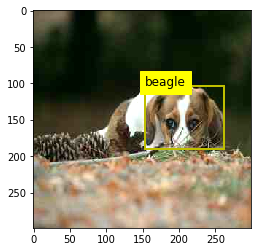

In [291]:
for x, y in train_set.take(1):
    n_image = 0
    categories, bounding_boxes = y
    category = categories[n_image].numpy()
    bounding_box = bounding_boxes[n_image].numpy()
    fig, ax = plt.subplots(1)
    ax.imshow(x[n_image].numpy())
    plt.text(
        bounding_box[0] * IMG_DIMS[0],
        bounding_box[1] * IMG_DIMS[1],
        get_category_name(le, category),
        backgroundcolor="yellow",
        fontsize=12,
    )
    y_rect = make_rectangle(*bounding_box, IMG_DIMS, "y")
    ax.add_patch(y_rect)
    plt.show()

In [281]:
n_categories = train_data["breed_encoded"].nunique()
n_categories

37

## Creating the model

In [0]:
class GlobalConcatPooling2D(keras.layers.Layer):
    def __call__(self, layer: keras.layers.Layer) -> keras.layers.Layer:
        return keras.layers.concatenate(
            [
                keras.layers.GlobalAvgPool2D()(layer),
                keras.layers.GlobalMaxPool2D()(layer),
            ]
        )

In [0]:
def make_model():
    base = tf.keras.applications.Xception(
        input_shape=IMG_DIMS, include_top=False, weights="imagenet"
    )
    x = GlobalConcatPooling2D()(base.output)
    x = keras.layers.Dropout(0.4)(x)
    category = keras.layers.Dense(n_categories, activation=keras.activations.softmax)(x)
    bounding_box = keras.layers.Dense(4, activation=keras.activations.sigmoid)(x)
    model = keras.Model(inputs=base.input, outputs=[category, bounding_box])
    model.compile(
        loss=[
            keras.losses.SparseCategoricalCrossentropy(),
            keras.losses.BinaryCrossentropy(),
        ],
        loss_weights=[0.5, 2.0],
        optimizer=keras.optimizers.Adam(3e-4),
    )
    return model

In [284]:
model = make_model()


83689472/83683744 [==============================] - 1s 0us/step


In [285]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [286]:
model.fit(
    x=train_set,
    validation_data=validation_set,
    steps_per_epoch=math.ceil(train_data.shape[0] / BATCH_SIZE),
    epochs=5,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            str(TEMP_DIR / "model1.h5"), save_best_only=True, save_weights_only=True
        ),
        keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=1),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ],
)

Train for 93 steps, validate for 12 steps
Epoch 1/5
93/93 [==============================] - 87s 935ms/step - loss: 1.7786 - dense_loss: 1.0522 - dense_1_loss: 0.6262 - val_loss: 1.3335 - val_dense_loss: 0.3050 - val_dense_1_loss: 0.5905
Epoch 2/5
93/93 [==============================] - 68s 727ms/step - loss: 1.2792 - dense_loss: 0.2195 - dense_1_loss: 0.5847 - val_loss: 1.2370 - val_dense_loss: 0.2345 - val_dense_1_loss: 0.5599
Epoch 3/5
93/93 [==============================] - 68s 727ms/step - loss: 1.1845 - dense_loss: 0.0852 - dense_1_loss: 0.5709 - val_loss: 1.2342 - val_dense_loss: 0.2443 - val_dense_1_loss: 0.5560
Epoch 4/5
93/93 [==============================] - 68s 728ms/step - loss: 1.1443 - dense_loss: 0.0447 - dense_1_loss: 0.5610 - val_loss: 1.1926 - val_dense_loss: 0.2062 - val_dense_1_loss: 0.5447
Epoch 5/5
93/93 [==============================] - 68s 727ms/step - loss: 1.1215 - dense_loss: 0.0294 - dense_1_loss: 0.5534 - val_loss: 1.1817 - val_dense_loss: 0.1944 - val

In [0]:
def predict(model, dataset, n_image=0):
    for x, y in dataset.take(1):
        fig, ax = plt.subplots(1)
        ax.imshow(x[n_image].numpy())

        p_categories, p_bounding_boxes = model.predict(x)
        p_category = p_categories[n_image].argmax()
        p_bounding_box = p_bounding_boxes[n_image]
        plt.text(
            (p_bounding_box[0] + p_bounding_box[2]) * IMG_DIMS[0] - 25,
            p_bounding_box[1] * IMG_DIMS[1],
            get_category_name(le, p_category),
            color="white",
            backgroundcolor="blue",
            fontsize=16,
        )
        p_rect = make_rectangle(*p_bounding_box, IMG_DIMS, "b", 3)
        ax.add_patch(p_rect)

        y_categories, y_bounding_boxes = y
        y_category = y_categories[n_image].numpy()
        y_bounding_box = y_bounding_boxes[n_image].numpy()
        plt.text(
            y_bounding_box[0] * IMG_DIMS[0] + 5,
            y_bounding_box[1] * IMG_DIMS[1],
            f"true:{get_category_name(le, y_category)}",
            backgroundcolor="red",
            fontsize=16,
        )
        y_rect = make_rectangle(*y_bounding_box, IMG_DIMS, "r")
        ax.add_patch(y_rect)

        plt.show()

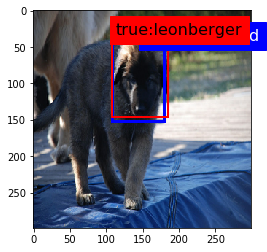

In [299]:
predict(model, validation_set, 1)


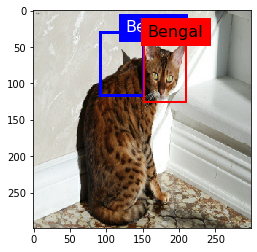

In [296]:
predict(model, validation_set, 10)


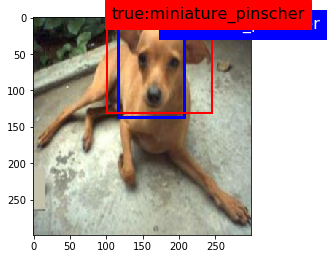

In [301]:
predict(model, test_set, 10)


In [0]:
def make_report(model, dataset):
    print(
        classification_report(
            [category.numpy() for _, (category, _) in dataset.unbatch()],
            model.predict(dataset)[0].argmax(axis=1),
            target_names=list(category_map.values()),
        )
    )

In [300]:
make_report(model, validation_set)


NameError: ignored